# Genetic Algorithm for Smart Charging and Discharging of EVs

This is an attempt to model the smart charging and discharging of EVs using Genetic Algorithm. The dataset used is a 96-point load data curve. The input parameters are:

1.   Duration
2.   Arrival Time
3.   Arrival SOC



In [117]:
import csv
import matplotlib.pyplot as plt
import random

# Vehicle Distribubtion
Data was collected and sampled from NHTS Survey

48
85


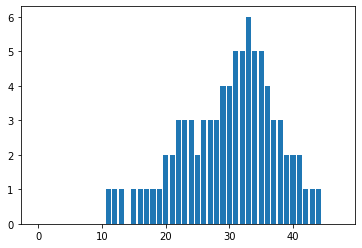

In [118]:
vehnum=[]
with open('./VPMARRIVAL1MIN.csv','r') as file:
    reader=csv.reader(file)
    i=0
    for row in reader:
        if i !=0 and i%2==0:
            vehnum.append(int(int(row[6])/1000))
        i+=1
print(len(vehnum))
# vehnum.sort()
vtot=0
for v in vehnum:
  vtot+=v
# print(vehnum[0],vehnum[95])
print(vtot)
plt.bar(range(len(vehnum)),vehnum)
plt.show()

#Genetic Algorithm

1. Initialization
2. Fitness Calculation
3. Parent Selection
4. Crossover
5. Mutation

Steps 2 through 5 are looped for a fixed number of times.


##Initialization

In [119]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

In [120]:
#util
def interval_intersection(interval1, interval2):
    if interval1[1] < interval2[0] or interval2[1] < interval1[0]:
        return []
    else:
        start = max(interval1[0], interval2[0])
        end = min(interval1[1], interval2[1])
        return [start, end]

Naive

In [121]:
# #initialize population
# import random
# best=-100000
# #parent_econload_gene=([random.randint(300,434) for x in range(5)])
# cars=[]
# soc=[random.uniform(0.8,1)for i in range(154)]
# print(len(soc))
# for t in range(0,48):
#   for i in range(0,vehnum[t]):
#     cars.append({"t":t,"d": random.randint(8,12),"Pev":[0 for x in range(96)]})
# i=0
# print(len(cars))
# for car in cars:
#   for t in range(car["t"],car["t"]+int(4*car["d"])):
#     interval=interval_intersection([-7.2,7.4],[-soc[i][t]*156,156-soc[i][t]*156])

#     if interval !=[]:
#       car["Pev"][t]=random.uniform(interval[0],interval[1])
#       #print(car["Pev"][t])
#   i+=1
# parent_cars_gene=([[random.randint(-1,1) for x in range(65)] for i in range(5)])
# new_populations = []
# print(cars)

In [122]:
dur=[random.randint(8,12) for x in range(vtot)]
len(dur)

85

Random shuffling of (-1,1)

In [123]:
#initialize population
from numpy import random
pop=500
#parent_econload_gene=([random.randint(300,434) for x in range(5)])
cars=[[clamp(random.normal(0,1.8),-7.2,7.4)/7.4 for i in range(vtot*96)]for x in range(pop)]
dur=[random.randint(8,12)*4 for x in range(vtot)]
start=[i for i in range(48) for v in range(vehnum[i])]
print(start)
end=[start[i]+dur[i] for i in range(vtot)]
#print(len(start))
soc=[0.0 for x in range(vtot*96) ]
# ebattery=[0.0 for x in range(vtot*96) ]
for j in range(vtot):
    soc[96*j+start[j]]=round(random.uniform(0.8,1),2)
ogsoc=soc

ebattery=[round(soc[96*x+start[x]]*39,2) for x in range(vtot)]
ogebattery=ebattery

t=0
arrival=vehnum+[0 for i in range(48)]
freq={}
for i in end:
  if i in freq:
    freq[i]+=1
  else:
    freq[i]=1
depart=[0 for i in range(96)]
for i in range(96):
  if i in freq:
    depart[i]=freq[i]

vehpresent=[0 for i in range(96)]
vehpresent[0]=arrival[0]-depart[0]

for i in range(1,96):
  vehpresent[i]=vehpresent[i-1]+arrival[i]-depart[i]


[11, 12, 13, 15, 16, 17, 18, 19, 20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 40, 40, 41, 41, 42, 43, 44]


In [124]:
ebattery

[35.49,
 35.88,
 32.37,
 31.59,
 33.54,
 39.0,
 31.98,
 36.27,
 31.98,
 38.22,
 34.71,
 36.66,
 33.54,
 31.98,
 35.1,
 31.59,
 33.93,
 33.15,
 35.49,
 37.05,
 34.71,
 38.61,
 39.0,
 34.32,
 33.93,
 36.66,
 38.61,
 38.61,
 37.05,
 38.22,
 37.05,
 34.32,
 38.22,
 37.44,
 31.59,
 37.44,
 35.49,
 35.88,
 37.05,
 34.32,
 34.32,
 35.1,
 34.32,
 33.15,
 35.1,
 35.1,
 38.61,
 33.93,
 32.76,
 32.76,
 32.37,
 34.32,
 36.66,
 35.88,
 32.76,
 35.1,
 33.93,
 31.98,
 32.76,
 39.0,
 33.15,
 37.44,
 34.71,
 37.44,
 36.66,
 37.44,
 32.76,
 37.05,
 32.76,
 37.83,
 37.44,
 33.54,
 37.05,
 37.05,
 32.37,
 32.37,
 33.54,
 33.15,
 34.71,
 35.1,
 38.22,
 33.93,
 31.98,
 37.05,
 31.59]

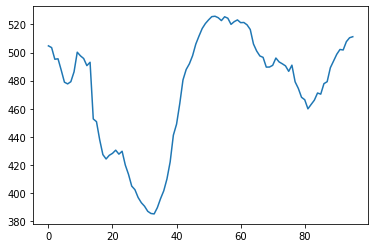

In [125]:
global P_load
P_load=[]
with open('./loadcurve.csv','r') as file:
    reader=csv.reader(file)
    i=0
    for row in reader:
        if i !=0:
            P_load.append(float(row[4]))
        i+=1

plt.plot(P_load)


##Fitness Score Calculation

In [126]:

import numpy as np

def fitness():
  global cars, P_load,fit_value,soc_value,best_fitness,pev
  best_fitness=-100000
  pev=7.4
  fit_value=[]
  soc_value=[]
  for i in range(0,pop):
    obj_fun=0
    P_econload=460
    reward=0
    soc=ogsoc
    ebattery=ogebattery
    for t in range(0,96):
        sum_pev=0
        for j in range(0,vtot):
            if start[j]<t<=end[j]:
              val=ebattery[j]+cars[i][t*vtot+j]*pev/4
              if round(val,2)>=0.4*39 and round(val,2)<39:
                ebattery[j]=round(val,2)
                sum_pev+=cars[i][t*vtot+j]*pev
                soc[96*j+t]=round((ebattery[j])/39,2)
          
            if t==end[j]:
              # print(soc[96*j+end[j]])
              if 0.9<=soc[96*j+end[j]]<=1:
                # print(2) 
                reward+=0.8
              if 0.7<=soc[96*j+end[j]]<0.9:
                reward+=0.5
              if 0.5<soc[96*j+end[j]]<0.7:
                reward+=0.1
            if t>end[j]:
              soc[96*j+t]=soc[96*j+end[j]]
        # print(P_load[t]-P_econload,sum_pev)
        obj_fun+=(P_load[t]-P_econload+sum_pev)
      
    fitness_score=10000/abs(obj_fun+1e-8)
    # print("fitness:",fitness_score)
    #print("reward:", reward)
    fitness_score=fitness_score+reward/100
    #1000 worked well
    fit_value.append(fitness_score)
    soc_value.append(soc)

    


In [127]:
#selecting parents....

def selectparent():
    global fit_value,parents,best_soc,best_fitness
    parents =[[0.0 for i in range(vtot*96)]for j in range(2*pop)]
    best_soc=[0.0 for i in range(vtot*96)]
    max_fitness_idx= np.argmax(fit_value)
    best_fitness=fit_value[max_fitness_idx]
    best_soc=soc_value[max_fitness_idx]
    # print(max(fit_value),best_fitness)
    # best_fit_index=-1
    # for parent_num in range(500):

    #     max_fitness_idx_arr = np.where(fit_value == np.max(fit_value))
    #     max_fitness_idx = max_fitness_idx_arr[0][0]
        
    #     parents[parent_num] = cars[max_fitness_idx]
    #     if best_fitness<fit_value[max_fitness_idx]:
    #         best_fitness=max(fit_value[max_fitness_idx],best_fitness)
    #         best_fit_index=max_fitness_idx
        
    #     fit_value[max_fitness_idx] = -99999999999
    # best_soc = soc_value[best_fit_index]
    tot_fit=sum(fit_value)
    probs=[i/tot_fit for i in fit_value]
    probs = sorted([(i, f/tot_fit) for i, f in enumerate(fit_value)], key=lambda p: p[1], reverse=True)
    
    for i in range(2*pop):
        x=random.uniform(0,1)
        j=0
        while(x>=probs[j][1]):
           x-=probs[j][1]
           j+=1
        parents[i]=cars[probs[j-1][0]]
    # print(len(parents))
# selectparent()
#print(len(parents))

## Crossover

In [128]:
# import numpy as np
# def PMX_crossover(parent1, parent2, seed):
#     '''
#     parent1 and parent2 are 1D np.array
#     '''
#     rng = np.random.default_rng(seed=seed)

#     cutoff_1, cutoff_2 = np.sort(rng.choice(np.arange(len(parent1)+1), size=2, replace=False))

#     def PMX_one_offspring(p1, p2):
#         offspring = np.zeros(len(p1), dtype=p1.dtype)

#         # Copy the mapping section (middle) from parent1
#         offspring[cutoff_1:cutoff_2] = p1[cutoff_1:cutoff_2]

#         # copy the rest from parent2 (provided it's not already there
#         for i in np.concatenate([np.arange(0,cutoff_1), np.arange(cutoff_2,len(p1))]):
#             candidate = p2[i]
#             while candidate in p1[cutoff_1:cutoff_2]: # allows for several successive mappings
#                 print(f"Candidate {candidate} not valid in position {i}") # DEBUGONLY
#                 candidate = p2[np.where(p1 == candidate)[0][0]]
#             offspring[i] = candidate
#         return offspring

#     offspring1 = PMX_one_offspring(parent1, parent2)
#     offspring2 = PMX_one_offspring(parent2, parent1)
#     parents=parents+offspring1
#     parents=parents+offspring2

#     return offspring1, offspring2


# newcars=parents

In [129]:
from operator import add,sub
def crossover():
     global parents,offspring 
     offspring = [[0 for i in range(vtot*96)]for j in range(pop)]
     # The point at which crossover takes place between two parents. Usually, it is at the center.
     
 
     for k in range(pop):
         # Index of the first parent to mate.
         pshape=1000
         parent1_idx = 2*k
         # Index of the second parent to mate.
         parent2_idx = 2*k+1
         crossover_point = random.randint(0,vtot)
         for i in range(96):
         # The new offspring will have its first half of its genes taken from the first parent.
          offspring[k][i*vtot:(i*vtot+crossover_point)] = parents[parent1_idx][i*vtot:(i*vtot+crossover_point)]
         # The new offspring will have its second half of its genes taken from the second parent.
          offspring[k][(i*vtot+crossover_point):(i*vtot+vtot)] = parents[parent2_idx][(i*vtot+crossover_point):(i*vtot+vtot)]
#crossover()
#print(parents)
    

In [130]:
def mutation():
    global offspring
    for i,off in enumerate(offspring) :
        # The random value to be added to the gene.
          mut_val=0.001
          for j,g in enumerate(off):
            if random.uniform(0,1)<mut_val:
         
                offspring[i][j] = clamp(random.normal(0,1.8),-7.2,7.4)/7.4
    return offspring
#mutation()

In [131]:
global parents,best,offspring
new_pop=[[0 for i in range(vtot*96)]for j in range(pop)]
best=[]
count=0
for i in range(0,100):
    if count>=10:
      break
    if len(best)>=2 and abs(best[i-2]-best[i-1])<0.5:
      count+=1
    elif len(best)>=2 and  abs(best[i-2]-best[i-1])>=0.5:
      count=0
      
    fitness()
    selectparent() 
    crossover()
    offspring_mutation=mutation()
    new_pop = offspring_mutation
    cars=new_pop
    # print(len(cars))
    print("best",i,":",best_fitness)
    best.append(best_fitness)
    # print(fit_value[0])

best 0 : 9.943558101027016
best 1 : 9.507895254320283
best 2 : 9.658174846708464
best 3 : 9.607293572941058
best 4 : 9.965661737730061
best 5 : 9.372730452564417
best 6 : 9.495949413153307
best 7 : 9.271147371559175
best 8 : 9.352558942522434
best 9 : 9.440748305320632
best 10 : 9.657372266346885
best 11 : 9.090096142589656
best 12 : 9.146813952144939
best 13 : 9.351750314792223
best 14 : 10.04133816364011
best 15 : 9.102045924932916
best 16 : 9.145109425042259
best 17 : 9.191998632539683
best 18 : 9.151674190670294
best 19 : 9.605759606049071
best 20 : 9.046218705609697
best 21 : 8.734657625159318
best 22 : 9.948323709367614
best 23 : 8.924113583100887
best 24 : 9.344602583157766
best 25 : 8.930599458100218
best 26 : 8.816936309320862
best 27 : 9.13630123403465
best 28 : 9.793468406495668
best 29 : 9.069845794430838
best 30 : 9.061638511607967
best 31 : 9.102946392789258
best 32 : 9.140830205426541
best 33 : 9.012931543191227
best 34 : 8.884062427360973
best 35 : 8.742992765385358
bes

In [132]:
len(best_soc)/85

96.0

<function matplotlib.pyplot.show(close=None, block=None)>

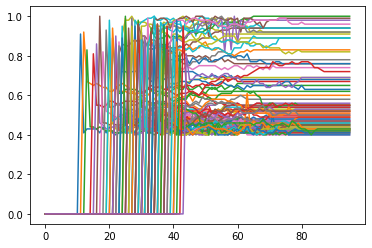

In [135]:
for j in range(vtot):
    plt.plot(best_soc[j*96:j*96+96])
plt.show